In [189]:
import sys
print(sys.executable)
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Batch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


/Users/anna/anaconda3/envs/tf_env/bin/python


## Creating Gating Network,MOE AND Expert wrapper ##

In [178]:
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        self.gate = nn.Linear(input_dim, num_experts)  # Outputs a score for each expert
        self.softmax = nn.Softmax(dim=-1)  # Converts scores into probabilities
    
    def forward(self, x):
        gate_scores = self.gate(x)  # Get expert selection scores
        gate_probs = self.softmax(gate_scores)  # Convert to probabilities
        return gate_probs  



In [179]:
class MoE(nn.Module):
    def __init__(self, gating_network, experts):
        super().__init__()
        self.gating = gating_network
        self.experts = nn.ModuleList(experts)

    def forward(self, x_gate, x_smi, x_mdm, x_gnn):
        gate_probs = self.gating(x_gate)
        expert_inputs = [x_smi, x_mdm, x_gnn]  
        expert_outputs = [expert(x_input) for expert, x_input in zip(self.experts, expert_inputs)]
        expert_outputs = torch.stack(expert_outputs, dim=1)  
        gate_probs = gate_probs.unsqueeze(-1)                
        return torch.sum(gate_probs * expert_outputs, dim=1) 


In [180]:
class Experts(nn.Module):
    def __init__(self, model, model_type):
        super().__init__()
        self.model = model
        self.model_type = model_type

    def forward(self, x):
        if self.model_type == 'gnn':
            x = x.to(next(self.model.parameters()).device)
            out = self.model(x)  
            return out.view(-1, 1)  

        elif self.model_type in ['smi', 'mdm']:
            pred = self.model.predict(x) 
            return torch.tensor(pred, dtype=torch.float32).view(-1, 1)  
                 


## Loading the models ##

In [181]:

import os

solvation_path = os.path.abspath(os.path.join(os.path.abspath(''), "../pnnlsolpaper"))
sys.path.append(solvation_path)
print("✅ Now at:", os.getcwd())

import smi
import mdm
import gnn
from keras.models import load_model
from torch_geometric.data import DataLoader

# loading gnn model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn.gnn_model.GNN(n_features=gnn.config.n_features).to(device)
gnn_model.load_state_dict(torch.load(os.path.join(solvation_path, "gnn", gnn.config.best_model)))

# loading smi model
smi_model = load_model(os.path.join(solvation_path, "smi", smi.config.best_model))

# loading mdm model
mdm_model = load_model(os.path.join(solvation_path, "mdm", mdm.config.best_model))


expert1 = Experts(model=smi_model, model_type='smi')  
expert2 = Experts(model=mdm_model, model_type='mdm')
expert3 = Experts(model=gnn_model, model_type='gnn')

experts = [expert1, expert2, expert3]





✅ Now at: /Users/anna/robertos/Solvation/MOE 2


## loading data ##

In [182]:
import numpy as np
import gzip
import pickle
from torch_geometric.data import Data
# loading full train data(probably not needed)
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
# Loading SMI Data 
smi_x_train = np.loadtxt(os.path.join(solvation_path,"smi/input/x_train.txt"))
smi_x_test = np.loadtxt(os.path.join(solvation_path,"smi/input/x_test.txt"))
smi_x_val = np.loadtxt(os.path.join(solvation_path,"smi/input/x_val.txt"))

# Loading MDM Data
mdm_x_train = np.loadtxt(os.path.join(solvation_path,"mdm/input/x_train.txt"))
mdm_x_test = np.loadtxt(os.path.join(solvation_path,"mdm/input/x_test.txt"))
mdm_x_val = np.loadtxt(os.path.join(solvation_path,"mdm/input/x_val.txt"))

# Loading GNN Data
data_path = os.path.join(solvation_path,'data/')
def load_pickled_data(file_path):
    with gzip.open(file_path, "rb") as f:
        return pickle.load(f)
gnn_train = load_pickled_data(os.path.join(data_path,"train.pkl.gz"))
gnn_test = load_pickled_data(os.path.join(data_path,"test.pkl.gz"))        
gnn_val = load_pickled_data(os.path.join(data_path,"val.pkl.gz"))

# Loading y data(either could be used)
y_train = np.loadtxt(os.path.join(solvation_path,"mdm/input/y_train.txt"))
y_test = np.loadtxt(os.path.join(solvation_path,"mdm/input/y_test.txt"))
y_val = np.loadtxt(os.path.join(solvation_path,"mdm/input/y_val.txt"))

                        
                        





## CREATING ENCODERS TO EMBEDD DATA FOR GATING NETWORK


In [183]:
import torch
import torch.nn as nn
import numpy as np

# Define MDMEncoder
class MDMEncoder(nn.Module):
    def __init__(self, input_dim=248, hidden_dim=128, out_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

# Convert numpy arrays to torch tensors
x_mdm_train = torch.tensor(mdm_x_train, dtype=torch.float32)
x_mdm_test = torch.tensor(mdm_x_test, dtype=torch.float32)
x_mdm_val = torch.tensor(mdm_x_val, dtype=torch.float32)

# Initialize encoder
input_dim = mdm_x_train.shape[1]
mdm_encoder = MDMEncoder(input_dim=input_dim)

# Embedding extraction function
def get_mdm_embeddings(encoder, mdm_tensor):
    encoder.eval()
    with torch.no_grad():
        return encoder(mdm_tensor)

# Generate embeddings
f_mdm_train = get_mdm_embeddings(mdm_encoder, x_mdm_train)
f_mdm_test = get_mdm_embeddings(mdm_encoder, x_mdm_test)
f_mdm_val = get_mdm_embeddings(mdm_encoder, x_mdm_val)


In [184]:
import torch
import torch.nn as nn
import numpy as np

# Define SMIEncoder class
class SMIEncoder(nn.Module):
    def __init__(self, vocab_size, maxlen, embedding_dim=64, out_dim=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 64, batch_first=True, bidirectional=True)
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(maxlen * 128, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.lstm(x)
        return self.output_layer(x)

# Convert numpy arrays to PyTorch tensors
x_smi_train = torch.tensor(smi_x_train, dtype=torch.long)
x_smi_test = torch.tensor(smi_x_test, dtype=torch.long)
x_smi_val = torch.tensor(smi_x_val, dtype=torch.long)

# Set vocabulary size and sequence length
vocab_size = int(np.max([smi_x_train.max(), smi_x_test.max(), smi_x_val.max()])) + 1
maxlen = smi_x_train.shape[1]  

# Initialize encoder
smi_encoder = SMIEncoder(vocab_size=vocab_size, maxlen=maxlen)

# Embedding extraction function
def get_smi_embeddings(encoder, smi_tensor):
    encoder.eval()
    with torch.no_grad():
        return encoder(smi_tensor)

# Generate embeddings
f_smi_train = get_smi_embeddings(smi_encoder, x_smi_train)
f_smi_test = get_smi_embeddings(smi_encoder, x_smi_test)
f_smi_val = get_smi_embeddings(smi_encoder, x_smi_val)

    

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle, gzip
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

# Define GNN Encoder
class GNNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_dim=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return global_mean_pool(x, batch)  

# Function to compute GNN embeddings
def get_gnn_embeddings(graph_dataset, encoder, batch_size=32):
    loader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=False)
    embeddings = []
    
    encoder.eval()
    with torch.no_grad():
        for batch in loader:
            emb = encoder(batch.x, batch.edge_index, batch.batch)
            embeddings.append(emb)
    
    return torch.cat(embeddings, dim=0)


# Initialize model
input_dim = gnn_train[0].x.shape[1]
gnn_encoder = GNNEncoder(in_channels=input_dim)

# Generate embeddings
f_gnn_train = get_gnn_embeddings(gnn_train, gnn_encoder)
f_gnn_val = get_gnn_embeddings(gnn_val, gnn_encoder)
f_gnn_test = get_gnn_embeddings(gnn_test, gnn_encoder)


/Users/anna/anaconda3/envs/tf_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Training Gating Network ##

In [187]:

#  Configuration
config = {
    'batch_size': 64,
    'num_epochs': 1000,
    'lr': 1e-3,
    'patience': 25,
    'save_path': 'best_moe_model5.pt',
    'num_experts': 3
}


# Dataset + Collate 
class MoEDataset(Dataset):
    def __init__(self, X_smi, X_mdm, X_gnn, X_gate, y):
        self.X_smi = X_smi
        self.X_mdm = X_mdm
        self.X_gnn = X_gnn
        self.X_gate = X_gate
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X_gate[idx], dtype=torch.float32), 
            torch.tensor(self.X_smi[idx], dtype=torch.float32),   
            torch.tensor(self.X_mdm[idx], dtype=torch.float32),   
            self.X_gnn[idx],                                      
            self.y[idx]                                           
        )




def moe_collate_fn(batch):
    x_gate, x_smi, x_mdm, x_gnn, y = zip(*batch)
    return (
        torch.stack(x_gate),
        torch.stack(x_smi),
        torch.stack(x_mdm),
        Batch.from_data_list(x_gnn),  
        torch.stack(y)
    )


#  Checking to see if all input data are aligned
assert smi_x_train.shape[0] == mdm_x_train.shape[0] == len(gnn_train), "Mismatch in number of training samples!"
print(" All datasets are aligned by sample count.")

# Preparing datasets and loaders
x_gate_train = torch.cat([f_smi_train, f_mdm_train, f_gnn_train], dim=1)
x_gate_val   = torch.cat([f_smi_val,   f_mdm_val,   f_gnn_val],   dim=1)
x_gate_test  = torch.cat([f_smi_test,  f_mdm_test,  f_gnn_test],  dim=1)

train_dataset = MoEDataset(smi_x_train, mdm_x_train, gnn_train, x_gate_train, y_train)
val_dataset   = MoEDataset(smi_x_val,   mdm_x_val,   gnn_val,   x_gate_val,   y_val)
test_dataset  = MoEDataset(smi_x_test,  mdm_x_test,  gnn_test,  x_gate_test,  y_test)

BS = config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, collate_fn=embedded_collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BS, shuffle=True, collate_fn=embedded_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BS, shuffle=True, collate_fn=embedded_collate_fn)

# Initialize MoE Model 
input_dim = x_gate_train.shape[1]
gating_network = GatingNetwork(input_dim=input_dim, num_experts=config['num_experts'])

for expert in experts:
    for param in expert.parameters():
        param.requires_grad = False
moe_model.train()
moe_model = MoE(gating_network=gating_network, experts=experts)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, moe_model.parameters()), lr=config['lr'])
criterion = torch.nn.MSELoss()

# Training Loop with Early Stopping
best_val_loss = float('inf')
wait = 0
print("🔧 Starting training...")

for epoch in range(config['num_epochs']):
    moe_model.train()
    total_loss = 0

    for x_gate, x_smi, x_mdm, x_gnn, y in train_loader:
        optimizer.zero_grad()
        output = moe_model(x_gate, x_smi, x_mdm, x_gnn)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    moe_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_gate, x_smi, x_mdm, x_gnn, y in val_loader:
            output = moe_model(x_gate, x_smi, x_mdm, x_gnn)
            loss = criterion(output, y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        print("📌 Val loss improved — saving model.")
        best_val_loss = avg_val_loss
        torch.save(moe_model.state_dict(), config['save_path'])
        wait = 0
    else:
        wait += 1
        print(f"⏳ No improvement. Patience: {wait}/{config['patience']}")

    if wait >= config['patience']:
        print("🛑 Early stopping triggered.")
        break
moe_model.load_state_dict(torch.load(config['save_path']))
moe_model.eval()
test_loss = 0

with torch.no_grad():
    for x_gate, x_smi, x_mdm, x_gnn, y in test_loader:
        output = moe_model(x_gate, x_smi, x_mdm, x_gnn)
        loss = criterion(output, y.view(-1, 1))
        test_loss += loss.item()

print(f"✅ Training complete! Final Test Loss: {test_loss / len(test_loader):.4f}")

#



 All datasets are aligned by sample count.
🔧 Starting training...


/var/folders/rf/0sl0cpln5ndc2jkd28zdjft80000gn/T/ipykernel_18273/23364179.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.X_gate[idx], dtype=torch.float32),  # make sure x_gate is tensor


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/var/folders/rf/0sl0cpln5ndc2jkd28zdjft80000gn/T/ipykernel_18273/23364179.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.X_gate[idx], dtype=torch.float32),  # make sure x_gate is tensor


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

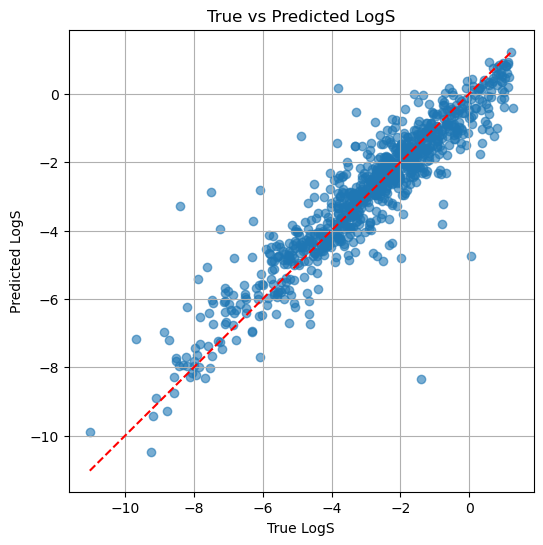

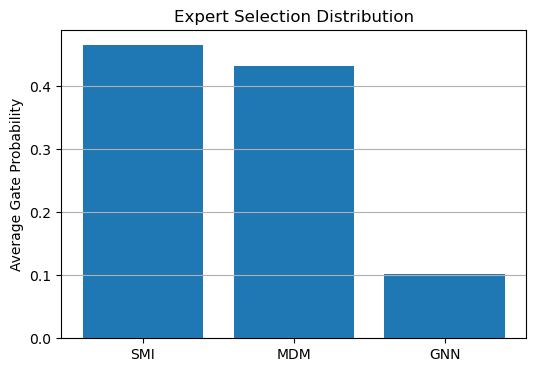

In [190]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    all_preds, all_targets, all_gates = [], [], []
    
    with torch.no_grad():
        for x_gate, x_smi, x_mdm, x_gnn, y in data_loader:
            preds = model(x_gate, x_smi, x_mdm, x_gnn)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
            all_gates.append(model.gating(x_gate).cpu().numpy())  # capture gate probs

    y_true = np.vstack(all_targets).flatten()
    y_pred = np.vstack(all_preds).flatten()
    gate_probs = np.vstack(all_gates)

    # Metrics
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    spearman = spearmanr(y_true, y_pred).correlation

    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Spearman Correlation: {spearman:.4f}")

    return y_true, y_pred, gate_probs

def plot_results(y_true, y_pred, gate_probs):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.xlabel("True LogS")
    plt.ylabel("Predicted LogS")
    plt.title("True vs Predicted LogS")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.grid(True)
    plt.show()

    # Bar plot: average gate selection
    avg_gate = gate_probs.mean(axis=0)
    experts = ["SMI", "MDM", "GNN"]
    plt.figure(figsize=(6, 4))
    plt.bar(experts, avg_gate)
    plt.ylabel("Average Gate Probability")
    plt.title("Expert Selection Distribution")
    plt.grid(axis='y')
    plt.show()

y_true, y_pred, gate_probs = evaluate_model(moe_model, test_loader, criterion)
plot_results(y_true, y_pred, gate_probs)